# Prevendo preços de escavadeiras com machine learning

Passos:
1. Definição do problema
2. Definição dos dados
3. Definir métrica de avaliação
4. Definir as features
5. Escolher o modelo
6. Experimentação

## 1. Definição do problema
Dados valores de venda passados, podemos prever por quanto uma escavadeira será vendida?

## 2. Dados
Fonte: Kaggle bluebook bulldozers.
> Train.csv is the training set, which contains data through the end of 2011.

> Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

> Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Métrica de avaliação
Minimizar o RMSLE (root mean squared log error)


## 4. Features
Data dictionary:
    
    SalesID	  unique identifier of a particular sale of a machine at auction
    MachineID	  identifier for a particular machine;  machines may have multiple sales
    ModelID	  identifier for a unique machine model (i.e. fiModelDesc)
    datasource	  source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.
    auctioneerID	  identifier of a particular auctioneer, i.e. company that sold the machine at auction.  Not the same as datasource.
    YearMade	  year of manufacturer of the Machine
    MachineHoursCurrentMeter	  current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale
    UsageBand	  value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel.
    Saledate	  time of sale
    Saleprice	  cost of sale in USD
    fiModelDesc	  Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor
    fiBaseModel	  disaggregation of fiModelDesc
    fiSecondaryDesc	  disaggregation of fiModelDesc
    fiModelSeries	  disaggregation of fiModelDesc
    fiModelDescriptor	  disaggregation of fiModelDesc
    ProductSize	  Don't know what this is 
    ProductClassDesc	  description of 2nd level hierarchical grouping (below ProductGroup) of fiModelDesc
    State	  US State in which sale occurred
    ProductGroup	  identifier for top-level hierarchical grouping of fiModelDesc
    ProductGroupDesc	  description of top-level hierarchical grouping of fiModelDesc
    Drive_System	machine configuration;  typcially describes whether 2 or 4 wheel drive
    Enclosure	machine configuration - does machine have an enclosed cab or not
    Forks	machine configuration - attachment used for lifting
    Pad_Type	machine configuration - type of treads a crawler machine uses
    Ride_Control	machine configuration - optional feature on loaders to make the ride smoother
    Stick	machine configuration - type of control 
    Transmission	machine configuration - describes type of transmission;  typically automatic or manual
    Turbocharged	machine configuration - engine naturally aspirated or turbocharged
    Blade_Extension	machine configuration - extension of standard blade
    Blade_Width	machine configuration - width of blade
    Enclosure_Type	machine configuration - does machine have an enclosed cab or not
    Engine_Horsepower	machine configuration - engine horsepower rating
    Hydraulics	machine configuration - type of hydraulics
    Pushblock	machine configuration - option
    Ripper	machine configuration - implement attached to machine to till soil
    Scarifier	machine configuration - implement attached to machine to condition soil
    Tip_control	machine configuration - type of blade control
    Tire_Size	machine configuration - size of primary tires
    Coupler	machine configuration - type of implement interface
    Coupler_System	machine configuration - type of implement interface
    Grouser_Tracks	machine configuration - describes ground contact interface
    Hydraulics_Flow	machine configuration - normal or high flow hydraulic system
    Track_Type	machine configuration - type of treads a crawler machine uses
    Undercarriage_Pad_Width	machine configuration - width of crawler treads
    Stick_Length	machine configuration - length of machine digging implement
    Thumb	machine configuration - attachment used for grabbing
    Pattern_Changer	machine configuration - can adjust the operator control configuration to suit the user
    Grouser_Type	machine configuration - type of treads a crawler machine uses
    Backhoe_Mounting	machine configuration - optional interface used to add a backhoe attachment
    Blade_Type	machine configuration - describes type of blade
    Travel_Controls	machine configuration - describes operator control configuration
    Differential_Type	machine configuration - differential type, typically locking or standard
    Steering_Controls	machine configuration - describes operator control configuration


In [50]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelos
from sklearn.ensemble import RandomForestRegressor
import pickle

# evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [6]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [14]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

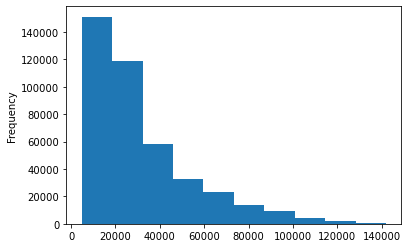

In [24]:
df.SalePrice.plot.hist();

## Parsing dates

In [37]:
df = pd.read_csv("data/TrainAndValid.csv", 
                 low_memory=False, 
                 parse_dates=["saledate"])

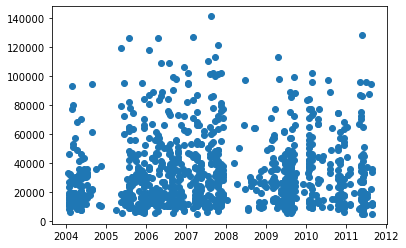

In [38]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [42]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)

## Feature engineering

In [43]:
# fazer uma cópia do DF original
df_tmp = df.copy()

### Adicionar atributos `datetime` para a coluna `saledate`

In [48]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.day_of_week
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.day_of_year

df_tmp.drop("saledate", axis=1, inplace==True)

## Modelagem
(model-driven EDA)

In [51]:
clf = RandomForestRegressor(n_jobs=-1)

X = df_tmp.drop("SalePrice", axis=1)
y = df_tmp["SalePrice"]

clf.fit(X, y)

ValueError: could not convert string to float: 'Medium'